# Registration

Correct for rigid/non-rigid movement

- Perfom motion-correction (rigid or piecewise-rigid) to eliminate movement in your movie.
- Run a grid-search across multiple sets of parameters.
- Use quality metrics to evaluate registration quality.

In [1]:
# Imports

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import pandas as pd

import numpy as np
import tifffile
from matplotlib import pyplot as plt
import fastplotlib as fpl

import caiman as cm
import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
from caiman.motion_correction import compute_metrics_motion_correction
import lbm_caiman_python as lcp

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (12, 8),
    'ytick.major.left': True,
})
jet = mpl.colormaps['jet']
jet.set_bad(color='k')

pd.options.display.max_colwidth = 120

WGPU: enumerate_adapters() is deprecated, use enumerate_adapters_sync() instead.
WGPU: request_adapter() is deprecated, use request_adapter_sync() instead.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.


## Data path setup

We set 2 path variables:

1. `data_path` : input, path where you saved the output from the assembly step
2. `batch_path` : results, can be anywhere you please, must end in .pickle

```{note}
This notebook assumes you saved scans as TIFF with `join_contiguous=True` so filenames are `plane_N.tiff`
The process for `join_contiguous=False` is the same, but with the roi attached to the filename `plane_N_roi_M`.
```
To simplify data management, we put our batch_path (which stores results) in the same directory as our raw data.

In [2]:
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out'  # where the output files from the assembly step are located
batch_path = data_path / 'batch_v2.pickle'

### Create or load a batch set

```{warning}
In the below if-else clause, be careful if you expect a batch to exist, a typo can be deceiving!
```

In [3]:
# Create or load a batch results file
# To overwrite:
# batch_df = mc.create_batch(batch_path, remove_existing=True)

if not batch_path.exists():
    print(f'creating batch: {batch_path}')
    df = mc.create_batch(batch_path)
else:
    df = mc.load_batch(batch_path)

# tell mesmerize where the raw data is
mc.set_parent_raw_data_path(data_path)

WindowsPath('C:/Users/RBO/caiman_data/out')

In [4]:
tiff_files = [x for x in Path(data_path).glob('*.tif*')]
tiff_files

[WindowsPath('C:/Users/RBO/caiman_data/out/plane_1.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_10.tif'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_11.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_12.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_13.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_14.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_15.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_16.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_17.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_18.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_19.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_2.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_20.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_21.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_22.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/plane_23.tiff'),
 WindowsPath('C:/Users/RBO/caiman_data/out/

### Load a data file to examine

In [5]:
file = tiff_files[1]
data = tifffile.memmap(file)
data.shape

(1730, 600, 576)

## View metadata

`lcp.get_metadata(filepath)` works on raw scanimage files and files processed through `lcp.save_as()`

In [6]:
metadata = lcp.get_metadata(file)
metadata

{'image_height': 2478,
 'image_width': 145,
 'num_pages': 51900,
 'ndim': 3,
 'dtype': 'uint16',
 'size': 18648189000,
 'shape': [51900, 2478, 145],
 'num_planes': 30,
 'num_rois': 4,
 'num_frames': 1730.0,
 'frame_rate': 9.60806,
 'fov': [150, 600],
 'pixel_resolution': [1.04, 1.0],
 'roi_width_px': 144,
 'roi_height_px': 600,
 'sample_format': 'int16',
 'num_lines_between_scanfields': 24,
 'center_xy': [-1.428571429, 0],
 'line_period': 4.15652e-05,
 'size_xy': [0.9523809524, 3.80952381],
 'objective_resolution': 157.5}

In [7]:
dxy = metadata['pixel_resolution']
print(f"Pixel resolution: {dxy[0]} um/px, {dxy[1]} um/px")

Pixel resolution: 1.04 um/px, 1.0 um/px


In [8]:
# note this is only for a single ROI
fov = metadata['fov']
print(f"Field of View: {fov[0]}px, {fov[1]}px")

Field of View: 150px, 600px


In [9]:
fr = metadata['frame_rate']
print(f"Frame rate: {fr} Hz")

Frame rate: 9.60806 Hz


# Registration parameters

| Parameter               | Description                                                                                     | Value/Default                  |
|-------------------------|-------------------------------------------------------------------------------------------------|--------------------------------|
| `dxy`                  | Spatial resolution (pixel size in micrometers).                                                 | `dxy` (from metadata)           |
| `fr`                   | Frame rate of the video (frames per second).                                                    | `fr` (from metadata)            |
| `max_shifts`           | Maximum allowed rigid shift in pixels for motion correction.                                     | `(int(10/dxy), int(10/dxy))`   |
| `strides`              | Size of patches for motion correction.                                                          | `[48, 48]`                     |
| `overlaps`             | Overlap between patches for motion correction.                                                  | `[24, 24]`                     |
| `max_deviation_rigid`  | Maximum allowed deviation for patches relative to rigid shifts.                                  | `3`                            |
| `border_nan`           | How to handle border values during motion correction.                                            | `'copy'`                       |
| `pw_rigid`             | Flag indicating whether to perform piecewise rigid motion correction.                            | `False`                        |
| `gSig_filt`            | Size of the Gaussian filter for smoothing the motion correction process.                         | `(3, 3)`                       |
| `shifts_opencv`        | Flag to use bicubic interpolation for motion correction.                                         | `True`                         |

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

## Using metadata to assign parameter values

```{important}
The goal here is to get an approximate neuron size in microns.
This value is used as the basis of the `patch` and `max_shifts` parameters.
```

`plot_data_with_scalebars` will give you 3 images, at 5, 10 and 20 um.

You can use any summary images:

```python
# a single frame
plot_with_scalebars(data[0, :, :], np.mean(dxy))           

# mean projection image
plot_with_scalebars(np.mean(data, axis=0), np.mean(dxy))  

# maximum projection image
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))    
```

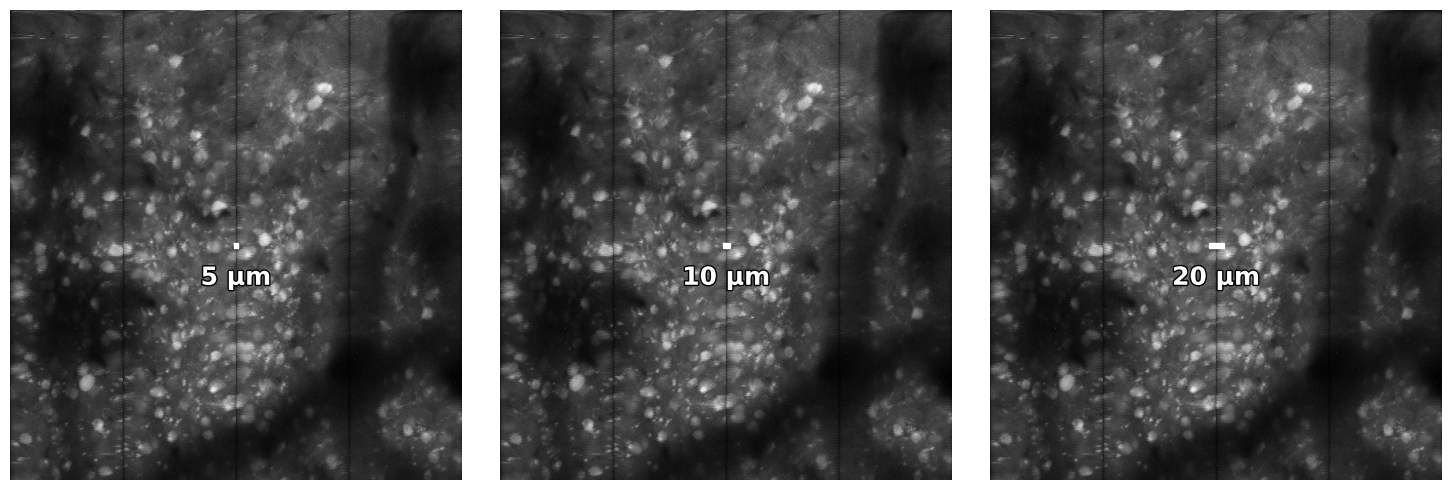

In [10]:
from lbm_caiman_python import plot_with_scalebars

# plot_with_scalebars(data[0, :, :], np.mean(dxy))
plot_with_scalebars(np.max(data, axis=0), np.mean(dxy))

## Scaling patches relative to neuron size

The `generate_patch_view` function divides the image into patches the same way CaImAn will do internally.

Increasing / decreasing the `target_patch_size` and `overlap_fraction` parameters to examine the effect of different stride/overlap values displayed in the title. 

```{tip}
We want each patch to have "landmarks" (neurons) to use for alignment, so we want at least a few full neurons for each patch.

For this reason, we use the `neuron_size` * `scale_factor` as our `target_patch_size`.

We want to **avoid** neurons occupying the inner regions of multiple neighboring patches.
```

In [11]:
neuron_size = 15    # in micron

# - value of 1 makes patches ~neuron sized
# - value of 2 makes patches ~2x neuron sized
# - the larger your neurons, the larger you want to make this number
scale_factor = 3 # must be > 0

overlap_fraction = 0.3  # 30% of the patch size will be overlap

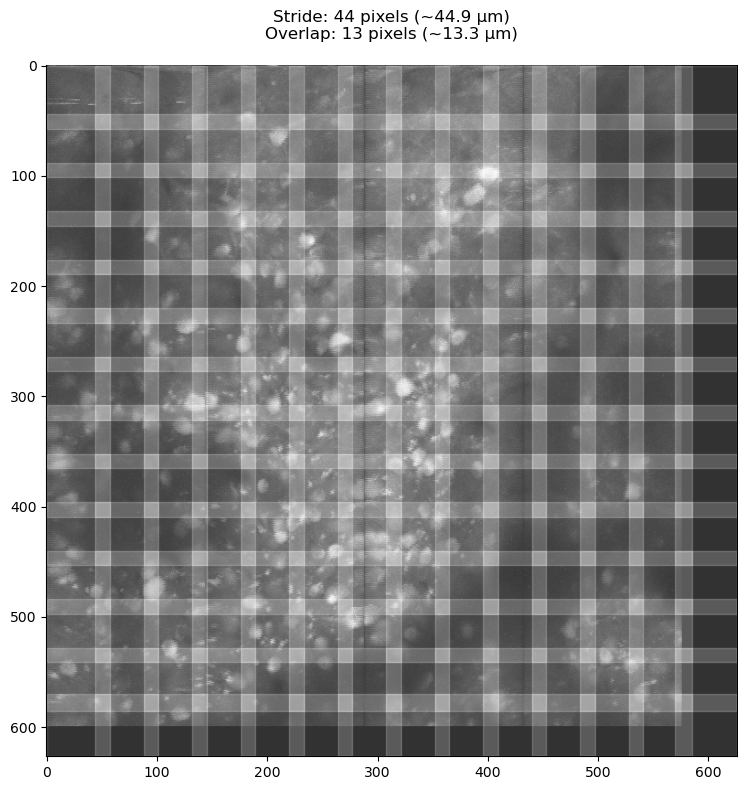

In [12]:
from lbm_caiman_python import generate_patch_view

target_patch_size=neuron_size*scale_factor    

# this function assumes a square pixel resolution, so take the mean
fig, ax, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
plt.show()

In [13]:
print(f'stride : {stride_px}px\noverlap: {overlap_px}px')

stride : 44px
overlap: 13px


In [14]:
# From the above image, we get our overlaps/strides parameters
# This is in *pixels*, not microns
strides = [stride_px, stride_px]
overlaps = [overlap_px, overlap_px]

## gSig_filt: Use a spatial filter to highlight cells and eliminate low-frequency spatial information (i.e. blood-vessels)

In the below widget, move the slider at the bottom titled 'gSig_filt' to see if adding a gaussian blur can help highlight neurons and hide blood-vessels.

In [18]:
from ipywidgets import IntSlider, VBox
from caiman.motion_correction import high_pass_filter_space

slider_gsig_filt = IntSlider(value=1, min=1, max=33, step=1,  description="high-pass-filter (σ)")
funcs = {1: lambda frame: high_pass_filter_space(frame, (slider_gsig_filt.value, slider_gsig_filt.value))}

# input movie will be shown on left, filtered on right
iw_gs = fpl.ImageWidget(
    data=[data, data],
    frame_apply=funcs,
    names=["raw", f"filtered"],
    figure_kwargs={"size": (1200, 600)},
    cmap="gnuplot2"
)

iw_gs.figure["filtered"].set_title(f"filtered σ={slider_gsig_filt.value}")

def force_update(*args):
    # forces the images to update when the gSig_filt slider is moved
    iw_gs.current_index = iw_gs.current_index
    iw_gs.reset_vmin_vmax()
    iw_gs.figure["filtered"].set_title(f"filtered σ={slider_gsig_filt.value}")

iw_gs.reset_vmin_vmax()
    
slider_gsig_filt.observe(force_update, "value")

VBox([iw_gs.show(), slider_gsig_filt])

RFBOutputContext()

In [19]:
iw_gs.close(); slider_gsig_filt.close()

## Create the parameters we pass to CaImAn

The above patch view looks good, so we use those values in our parameters dictionary.

You *can* also include segmentation parameters in this dictionary if you wish. This is *not recommmended* as several parameters share similar names yet perform different actions. i.e:
-  `stride` and `gSig_filt` parameters are for registration
-  `strides` for `gSig` are parameters for segmentation

```{note}
We want our parameters to physically make sense. 

`max_shifts` controls the maximum number of pixels that each individual patch can be shifted.

We don't want to shift any patches more than a full overlap which would introduce artifacts into neighboring patches.
```

In [15]:
max_shifts = (int(overlaps[0] / 2), int(overlaps[0] / 2))   # maximum allowed rigid shift in pixels 
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                       # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True                  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'dxy': dxy,
        'fr': fr,
        'max_shifts': max_shifts, # make sure its a tuple/list of integers
        'strides': strides,
        'overlaps': overlaps,
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': (3, 3),
    },
}

### Run registration with `mesmerize-core`

See the mesmerize-core [utility docs](https://mesmerize-core.readthedocs.io/en/latest/api/functions.html) for more information on batch creation.


### Add an item to the batch

A "batch item" consists of:
* algorithm to run, `algo` 
    - currently: mcorr, cnmf, cnmfe
* input movie to run the algorithm on, `input_movie_path`
    - can be string or dataframe row
* parameters for the specified algorithm, `params`
* a name for you to keep track of things `item_name`
    - can be anything

In [38]:
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=file,
    params=mcorr_params,
    item_name='mcorr',
)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d_mean_projection.n...,2024-12-12T14:10:27,2024-12-12T14:11:40,73.37 sec,None,d5723ed3-b4df-4df9-90d5-62eafae8033d


## First registration run

```{note}
On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.
For this reason, on windows you need to reload the dataframe:
```
```python
df=df.caiman.reload_from_disk()
df
```

If you ever get errors like 

```python
TypeError: NoneType is not subscriptable
```
**This likely means you need to reload the dataframe**.

```{warning}
On windows, `df.iloc[i].caiman.run()` will sometimes stall if you run additional cells before it completes.
```

In [17]:
df.iloc[0].caiman.run()

Running d5723ed3-b4df-4df9-90d5-62eafae8033d with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [39]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d_mean_projection.n...,2024-12-12T14:10:27,2024-12-12T14:11:40,73.37 sec,None,d5723ed3-b4df-4df9-90d5-62eafae8033d


### Check for errors in outputs

In the table header **outputs**, you should see 

```python
{'mean-projection-path': ...}
```
If you see instead:

```python
{'success': False, ...}
```

Run the below cell to evaluate the error message.

In [40]:
import pprint
pprint.pprint(df.iloc[0].outputs["traceback"])

None


## Evaluate motion correction outputs with `mesmerize-core` API 

mesmerize-core offers an easy [API](https://mesmerize-core.readthedocs.io/en/latest/api/mcorr.html) to retrieve results from the batch dataframe.

In [41]:
# get the motion corrected movie memmap
mcorr_movie = df.iloc[0].mcorr.get_output()

# the input movie, note that we use `.caiman` here instead of `.mcorr`
input_movie = df.iloc[0].caiman.get_input_movie()

### Side-by-side with `fastplotlib`

Its helpful to zoom into specific locations of your images to see improvements.

RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='900px')
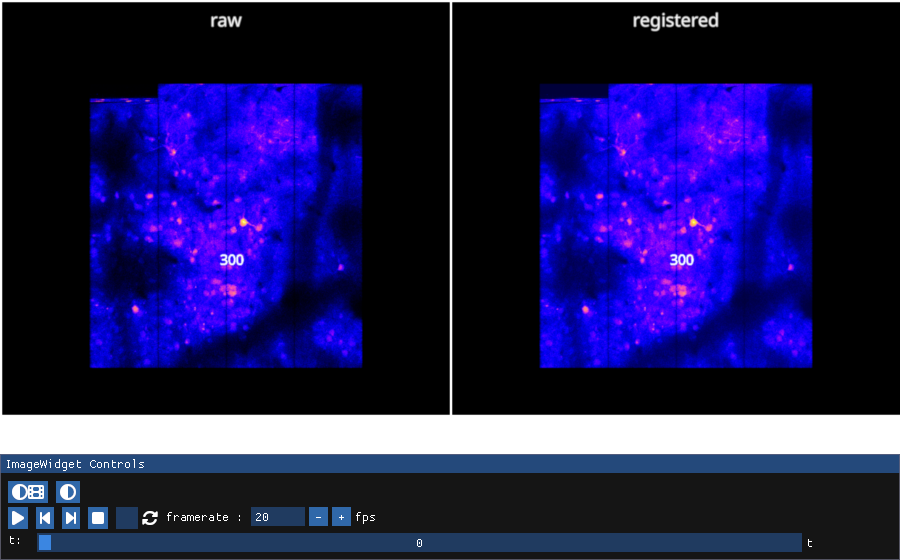

In [26]:
mcorr_iw = fpl.ImageWidget(
    data=[input_movie, mcorr_movie],
    names=['raw', 'registered'],
    cmap="gnuplot2",
    window_funcs={"t": (np.mean, 3)}, # window functions, can change to np.max, np.std, anything that operates on a timeseries
    figure_kwargs={"size": (900, 560)},
    histogram_widget=False, # helps keep plots close together
)
mcorr_iw.show()

In [27]:
mcorr_iw.close()

# Define parameter varients

If you still see non-rigid motion in your movie, we can try increasing the scale_factor to increase our patch-size or decrease it. 

More than likely you will want to decrease the scale factor to process more patches.

The patched graphs displayed show you what patches each of your movie will use.

```{tip}
The `item_name` parameter of `df.caiman.add_item()` is used to group similar batch results.
You should keep the `item_name` the same for grid search items.
```

In [ ]:
from copy import deepcopy

for scale in (1, 2, 4): # we started with a scale of 3
    for gSig in (0, 1, 2, 4): # very exaustive
        target_patch_size=neuron_size*scale    
        overlap_fraction = .3 # keep overlap to 30% of patch size
        
        _, _, stride_px, overlap_px = generate_patch_view(np.max(data, axis=0), pixel_resolution=np.mean(dxy), target_patch_size=target_patch_size, overlap_fraction=overlap_fraction)
        
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)
    
        new_shift = int(np.ceil(overlap_px / 2))
        new_stride = int(np.ceil(stride_px))
        new_overlap = int(np.ceil(overlap_px))
    
        new_params["main"]["max_shifts"] = (new_shift, new_shift)
        new_params["main"]["strides"] = (new_stride, new_stride)
        new_params["main"]["overlaps"] = (new_overlap, new_overlap)
        new_params["main"]["overlaps"] = (new_overlap, new_overlap)
        new_params["main"]["gSig_filt"] = (gSig, gSig)
    
        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',
        )

```{tip}
We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`.

This shows the parameters that differ between our batch items.
```

In [15]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

,max_shifts,overlaps,strides,gSig_filt
0,"(6, 6)","(13, 13)","(44, 44)","(3, 3)"
1,"(2, 2)","(4, 4)","(14, 14)","(0, 0)"
2,"(2, 2)","(4, 4)","(14, 14)","(1, 1)"
3,"(2, 2)","(4, 4)","(14, 14)","(2, 2)"
4,"(2, 2)","(4, 4)","(14, 14)","(4, 4)"
5,"(4, 4)","(8, 8)","(29, 29)","(0, 0)"
6,"(4, 4)","(8, 8)","(29, 29)","(1, 1)"
7,"(4, 4)","(8, 8)","(29, 29)","(2, 2)"
8,"(4, 4)","(8, 8)","(29, 29)","(4, 4)"
9,"(9, 9)","(17, 17)","(58, 58)","(0, 0)"


#### (Optional) Use your own grid-search values.

For example:

``` python
from copy import deepcopy

for shifts in [2,32]:
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["pw_rigid"] = True
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)

        df.caiman.add_item(
            algo='mcorr',
            input_movie_path=file,
            params=new_params,
            item_name='mcorr',  # filename of the movie, but can be anything
        )

df.caiman.reload_from_disk()
```

### Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [45]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running b6bbd066-bc91-43b7-9844-ac840528b16f with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 83086c5a-1cd5-4142-a5db-1cf20bc7f1c3 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running a3bf191f-9660-455e-a5fe-116a20112fce with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 575da23d-0907-4490-8680-53bf4241fdb9 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 09dd05e8-3fe8-493f-90c6-f3bedfb5f311 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 2a1a33ec-02f0-459d-a1a3-0d35ad5afd12 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 5ac3e070-4ad5-49c3-a193-e4713c85545f with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 5f2b4ebe-8b58-4285-b1f3-bc2500a388de with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 13624f38-d24a-4245-9bc5-6796426b303c with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running f7f4c603-670b-4d3a-804d-3699da309992 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 91f848b6-3da0-40e7-819e-10fb68d721a7 with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
Running 62454fc0-e3ee-4ab4-b535-bf616dab4d8f with local backend
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [46]:
# make sure everything works properly
# check for outputs {'success': False, ...
df = df.caiman.reload_from_disk()
df.outputs

0     {'mean-projection-path': d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d_mean_projection.n...
1     {'mean-projection-path': b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f_mean_projection.n...
2     {'mean-projection-path': 83086c5a-1cd5-4142-a5db-1cf20bc7f1c3\83086c5a-1cd5-4142-a5db-1cf20bc7f1c3_mean_projection.n...
3     {'mean-projection-path': a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce_mean_projection.n...
4     {'mean-projection-path': 575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9_mean_projection.n...
5     {'mean-projection-path': 09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311_mean_projection.n...
6     {'mean-projection-path': 2a1a33ec-02f0-459d-a1a3-0d35ad5afd12\2a1a33ec-02f0-459d-a1a3-0d35ad5afd12_mean_projection.n...
7     {'mean-projection-path': 5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f_mean_projecti

## Compute summary statistics

### You can evaluate some basic statistics like mean, median, and percentiles of each item in your batch results. 

It is possible that parameter sets you used for your grid-search yield the same output movie (i.e. overlaps of (2, 2) and (3, 3) likely yield the same result).

You will want to compute registration statistics (correlation, optical flow) later which is computationally expensive, so it helps to limit the batch items you will use as input.

In [83]:
summary_df = lcp.create_summary_df(df)
summary_df

Computing Data Summary: 100%|██████████████████████████████████████████████████████████| 14/14 [02:28<00:00, 10.60s/it]


,item_name,batch_index,min,max,mean,std,p1,p50,p99,uuid
0,Raw Data,None,-48.000000,14136.000000,1727.124516,1064.607905,99.000000,1613.000000,4719.000000,None
1,mcorr,0,-751.626099,13770.085938,1727.159058,1051.838135,116.617019,1619.721558,4676.681152,d5723ed3-b4df-4df9-90d5-62eafae8033d
2,mcorr,1,-705.083252,13970.670898,1727.931763,1040.428711,134.869751,1627.657837,4644.791992,b6bbd066-bc91-43b7-9844-ac840528b16f
3,mcorr,2,-663.921021,14037.961914,1727.577393,1050.627075,122.932434,1619.905640,4682.185063,83086c5a-1cd5-4142-a5db-1cf20bc7f1c3
4,mcorr,3,-463.997650,13975.410156,1727.147705,1052.359863,121.674316,1618.000000,4683.509277,a3bf191f-9660-455e-a5fe-116a20112fce
5,mcorr,4,-744.723145,14056.252930,1727.180664,1051.307129,121.286072,1618.864868,4678.113774,575da23d-0907-4490-8680-53bf4241fdb9
6,mcorr,5,-705.083252,13970.670898,1727.931763,1040.428711,134.869751,1627.657837,4644.791992,09dd05e8-3fe8-493f-90c6-f3bedfb5f311
7,mcorr,6,-322.983795,13868.529297,1727.315430,1055.096313,119.404007,1616.101929,4694.885742,2a1a33ec-02f0-459d-a1a3-0d35ad5afd12
8,mcorr,7,-753.015625,13880.610352,1727.143921,1055.337036,116.445404,1617.139709,4689.887207,5ac3e070-4ad5-49c3-a193-e4713c85545f
9,mcorr,8,-766.453857,13908.192383,1727.224365,1052.195679,118.526398,1619.127686,4679.006348,5f2b4ebe-8b58-4285-b1f3-bc2500a388de


### Find the duplicates

In [85]:
duplicate_rows = summary_df[summary_df.duplicated(subset=['min', 'max', 'mean', 'std', 'p1', 'p50', 'p99'], keep=False)]
duplicate_rows

,item_name,batch_index,min,max,mean,std,p1,p50,p99,uuid
2,mcorr,1,-705.083252,13970.670898,1727.931763,1040.428711,134.869751,1627.657837,4644.791992,b6bbd066-bc91-43b7-9844-ac840528b16f
6,mcorr,5,-705.083252,13970.670898,1727.931763,1040.428711,134.869751,1627.657837,4644.791992,09dd05e8-3fe8-493f-90c6-f3bedfb5f311
10,mcorr,9,-705.083252,13970.670898,1727.931763,1040.428711,134.869751,1627.657837,4644.791992,13624f38-d24a-4245-9bc5-6796426b303c


### Drop the duplicates from our batch dataframe

In [92]:
df = df.drop(index=duplicate_rows.index)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d_mean_projection.n...,2024-12-12T14:10:27,2024-12-12T14:11:40,73.37 sec,None,d5723ed3-b4df-4df9-90d5-62eafae8033d
1,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f_mean_projection.n...,2024-12-12T14:30:04,2024-12-12T14:32:39,116.51 sec,None,b6bbd066-bc91-43b7-9844-ac840528b16f
3,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce_mean_projection.n...,2024-12-12T14:30:05,2024-12-12T14:36:35,117.24 sec,None,a3bf191f-9660-455e-a5fe-116a20112fce
4,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': 575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9_mean_projection.n...,2024-12-12T14:30:05,2024-12-12T14:38:33,117.94 sec,None,575da23d-0907-4490-8680-53bf4241fdb9
5,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:39:55,82.13 sec,None,09dd05e8-3fe8-493f-90c6-f3bedfb5f311
7,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:42:41,82.49 sec,None,5ac3e070-4ad5-49c3-a193-e4713c85545f
8,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 5f2b4ebe-8b58-4285-b1f3-bc2500a388de\5f2b4ebe-8b58-4285-b1f3-bc2500a388de_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:44:04,83.89 sec,None,5f2b4ebe-8b58-4285-b1f3-bc2500a388de
9,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (9, 9), 'strides': (58, 58), 'overlaps': (17, 17), 'max_d...",{'mean-projection-path': 13624f38-d24a-4245-9bc5-6796426b303c\13624f38-d24a-4245-9bc5-6796426b303c_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:45:17,72.16 sec,None,13624f38-d24a-4245-9bc5-6796426b303c
11,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (9, 9), 'strides': (58, 58), 'overlaps': (17, 17), 'max_d...",{'mean-projection-path': 91f848b6-3da0-40e7-819e-10fb68d721a7\91f848b6-3da0-40e7-819e-10fb68d721a7_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:47:42,73.05 sec,None,91f848b6-3da0-40e7-819e-10fb68d721a7
12,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (9, 9), 'strides': (58, 58), 'overlaps': (17, 17), 'max_d...",{'mean-projection-path': 62454fc0-e3ee-4ab4-b535-bf616dab4d8f\62454fc0-e3ee-4ab4-b535-bf616dab4d8f_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:48:57,74.39 sec,None,62454fc0-e3ee-4ab4-b535-bf616dab4d8f


### Reload our dataframe if you made a mistake

In [93]:
df = df.caiman.reload_from_disk()
df.head()

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d_mean_projection.n...,2024-12-12T14:10:27,2024-12-12T14:11:40,73.37 sec,None,d5723ed3-b4df-4df9-90d5-62eafae8033d
1,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f_mean_projection.n...,2024-12-12T14:30:04,2024-12-12T14:32:39,116.51 sec,None,b6bbd066-bc91-43b7-9844-ac840528b16f
2,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': 83086c5a-1cd5-4142-a5db-1cf20bc7f1c3\83086c5a-1cd5-4142-a5db-1cf20bc7f1c3_mean_projection.n...,2024-12-12T14:30:04,2024-12-12T14:34:38,118.42 sec,None,83086c5a-1cd5-4142-a5db-1cf20bc7f1c3
3,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce_mean_projection.n...,2024-12-12T14:30:05,2024-12-12T14:36:35,117.24 sec,None,a3bf191f-9660-455e-a5fe-116a20112fce
4,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': 575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9_mean_projection.n...,2024-12-12T14:30:05,2024-12-12T14:38:33,117.94 sec,None,575da23d-0907-4490-8680-53bf4241fdb9
5,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:39:55,82.13 sec,None,09dd05e8-3fe8-493f-90c6-f3bedfb5f311
6,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 2a1a33ec-02f0-459d-a1a3-0d35ad5afd12\2a1a33ec-02f0-459d-a1a3-0d35ad5afd12_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:41:18,82.63 sec,None,2a1a33ec-02f0-459d-a1a3-0d35ad5afd12
7,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:42:41,82.49 sec,None,5ac3e070-4ad5-49c3-a193-e4713c85545f
8,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 5f2b4ebe-8b58-4285-b1f3-bc2500a388de\5f2b4ebe-8b58-4285-b1f3-bc2500a388de_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:44:04,83.89 sec,None,5f2b4ebe-8b58-4285-b1f3-bc2500a388de
9,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (9, 9), 'strides': (58, 58), 'overlaps': (17, 17), 'max_d...",{'mean-projection-path': 13624f38-d24a-4245-9bc5-6796426b303c\13624f38-d24a-4245-9bc5-6796426b303c_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:45:17,72.16 sec,None,13624f38-d24a-4245-9bc5-6796426b303c


### Or save the duplicates to disk

In [ ]:
# COMMENTED OUT SO YOU DONT ACCIDENTALLY RUN THIS

# batch_df.drop(index=duplicate_rows.index, inplace=True, reset_index=True)
# batch_df.caiman.save_to_disk(max_index_diff=len(duplicate_rows.index))

In [105]:
# Now our results are saved to disk with index
df = df.caiman.reload_from_disk()
df.head()

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (6, 6), 'strides': (44, 44), 'overlaps': (13, 13), 'max_d...",{'mean-projection-path': d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d_mean_projection.n...,2024-12-12T14:10:27,2024-12-12T14:11:40,73.37 sec,None,d5723ed3-b4df-4df9-90d5-62eafae8033d
1,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f_mean_projection.n...,2024-12-12T14:30:04,2024-12-12T14:32:39,116.51 sec,None,b6bbd066-bc91-43b7-9844-ac840528b16f
3,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce_mean_projection.n...,2024-12-12T14:30:05,2024-12-12T14:36:35,117.24 sec,None,a3bf191f-9660-455e-a5fe-116a20112fce
4,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (14, 14), 'overlaps': (4, 4), 'max_dev...",{'mean-projection-path': 575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9_mean_projection.n...,2024-12-12T14:30:05,2024-12-12T14:38:33,117.94 sec,None,575da23d-0907-4490-8680-53bf4241fdb9
5,mcorr,mcorr,plane_10.tif,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (4, 4), 'strides': (29, 29), 'overlaps': (8, 8), 'max_dev...",{'mean-projection-path': 09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311_mean_projection.n...,2024-12-12T14:30:06,2024-12-12T14:39:55,82.13 sec,None,09dd05e8-3fe8-493f-90c6-f3bedfb5f311


## Compute evaluation metrics

### A few simple metrics to evaluate performance of registration across several batch runs. 

| **Metric**       | **Description**                                           | **Higher or Lower is Better?** |
|------------------|----------------------------------------------------------|----------------------------------|
| **Correlations**  | How similar each frame is to a reference "template" frame. | **Higher is better** (closer to 1 means frames are more similar) |
| **Norms**         | The amount of movement or change in each frame.            | **Lower is better** (less movement indicates stability) |
| **Smoothness**    | How smooth/sharp/crisp the image appears.                     | **Higher is better** (crisper mean image) |
| **Flows**         | The direction and speed of pixel movement between frames.  | **Lower "better"** (less movement relative to mean image) |
| **Smoothness (correlations)** | How smooth the image of frame-to-frame correlations appears. | **Higher is better** (higher smoothness means sharper correlation map) |
| **Image Correlations** | Shows the local similarity of neighboring pixels in each frame. | **Higher is better** (higher local similarity means more consistent images) |

Many of these metrics are related. `Norms` is a measure of the stregnth of `flows` (which also include direction). `Smoothness` measures sharpness of edges which typically result in high`correlations` because individual pixels are located in the same location.

For more a technical discussion on these metrics, see [NoRMCorre's companion paper](https://www.sciencedirect.com/science/article/pii/S0165027017302753#sec0010) (section 2.2.1 - 2.2.4, 3.2.1 - 3.2.4).

### `compute_batch_metrics(df, overwrite=False)`

Feed your batch dataframe to `compute_batch_metrics` to compute each of these metrics and save them to disk.

This functiion will attempt to locate your raw data path to run evaluation metrics on the raw input-file for comparison.

Use `overwrite=False` to avoid re-calculating these values.

```{warning}
`compute_batch_metrics()` is a computationally intensive function. ~70s per batch item on a `600 x 576` pixel image with 1760 frames.
```
The returned `metrics_files` containes a list of paths to the saved metrics.

In [106]:
metrics_files = lcp.compute_batch_metrics(df, overwrite=True)

Overwriting raw metrics file C:\Users\RBO\caiman_data\out\plane_10_metrics.npz.
Computing metrics for C:\Users\RBO\AppData\Local\Temp\tmpv9z3k1m4.tiff


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.52it/s]


Computed metrics for raw data in 56.25 seconds.
Processing batch index 0...
Overwriting metrics file C:\Users\RBO\caiman_data\out\d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.43it/s]


Computed metrics for batch index 0 in 57.01 seconds.
Processing batch index 1...
Overwriting metrics file C:\Users\RBO\caiman_data\out\b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.57it/s]


Computed metrics for batch index 1 in 56.41 seconds.
Processing batch index 3...
Overwriting metrics file C:\Users\RBO\caiman_data\out\a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.48it/s]


Computed metrics for batch index 3 in 56.76 seconds.
Processing batch index 4...
Overwriting metrics file C:\Users\RBO\caiman_data\out\575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.51it/s]


Computed metrics for batch index 4 in 57.00 seconds.
Processing batch index 5...
Overwriting metrics file C:\Users\RBO\caiman_data\out\09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.55it/s]


Computed metrics for batch index 5 in 56.33 seconds.
Processing batch index 7...
Overwriting metrics file C:\Users\RBO\caiman_data\out\5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.57it/s]


Computed metrics for batch index 7 in 56.43 seconds.
Processing batch index 8...
Overwriting metrics file C:\Users\RBO\caiman_data\out\5f2b4ebe-8b58-4285-b1f3-bc2500a388de\5f2b4ebe-8b58-4285-b1f3-bc2500a388de-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\5f2b4ebe-8b58-4285-b1f3-bc2500a388de\5f2b4ebe-8b58-4285-b1f3-bc2500a388de-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.52it/s]


Computed metrics for batch index 8 in 56.51 seconds.
Processing batch index 9...
Overwriting metrics file C:\Users\RBO\caiman_data\out\13624f38-d24a-4245-9bc5-6796426b303c\13624f38-d24a-4245-9bc5-6796426b303c-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\13624f38-d24a-4245-9bc5-6796426b303c\13624f38-d24a-4245-9bc5-6796426b303c-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.56it/s]


Computed metrics for batch index 9 in 56.51 seconds.
Processing batch index 11...
Overwriting metrics file C:\Users\RBO\caiman_data\out\91f848b6-3da0-40e7-819e-10fb68d721a7\91f848b6-3da0-40e7-819e-10fb68d721a7-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\91f848b6-3da0-40e7-819e-10fb68d721a7\91f848b6-3da0-40e7-819e-10fb68d721a7-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.42it/s]


Computed metrics for batch index 11 in 57.19 seconds.
Processing batch index 12...
Overwriting metrics file C:\Users\RBO\caiman_data\out\62454fc0-e3ee-4ab4-b535-bf616dab4d8f\62454fc0-e3ee-4ab4-b535-bf616dab4d8f-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730_metrics.npz.
Computing metrics for C:\Users\RBO\caiman_data\out\62454fc0-e3ee-4ab4-b535-bf616dab4d8f\62454fc0-e3ee-4ab4-b535-bf616dab4d8f-plane_10_els__d1_600_d2_576_d3_1_order_F_frames_1730.mmap


Optical flow: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:36<00:00,  9.49it/s]


Computed metrics for batch index 12 in 56.66 seconds.


### Load metrics into a dataframe

`lcp.create_metrics_df()` will use the resulting filepaths to load the **mean** metric statistic, along with the path to the metrics file.

This gives you an overview of the best results. The metric_path is needed to load larger arrays for plotting that don't performantly fit into a dataframe cell.

```{note}
batch_index = -1 for your *raw data*. This does not correspond to the 'last index', as it does with numpy slicing. It is just convenient to avoid casting another data type like str/np.null.
```

In [6]:
metrics_df = lcp.create_metrics_df(metrics_files)
metrics_df

,mean_corr,mean_norm,crispness,uuid,batch_index,metric_path
0,0.915155,266.321655,22.529648,raw_b8a09dda-66aa-4a98-b86b-fcfed29c16a3,-1,C:\Users\RBO\caiman_data\out\plane_10_metrics.npz
1,0.927072,71.192482,23.820064,d5723ed3-b4df-4df9-90d5-62eafae8033d,0,C:\Users\RBO\caiman_data\out\d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d-plane_10_els_...
2,0.935468,268.513214,22.374401,b6bbd066-bc91-43b7-9844-ac840528b16f,1,C:\Users\RBO\caiman_data\out\b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f-plane_10_els_...
3,0.927206,82.862724,23.653557,a3bf191f-9660-455e-a5fe-116a20112fce,3,C:\Users\RBO\caiman_data\out\a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce-plane_10_els_...
4,0.927685,108.530457,23.656135,575da23d-0907-4490-8680-53bf4241fdb9,4,C:\Users\RBO\caiman_data\out\575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9-plane_10_els_...
5,0.935468,268.513214,22.374401,09dd05e8-3fe8-493f-90c6-f3bedfb5f311,5,C:\Users\RBO\caiman_data\out\09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311-plane_10_els_...
6,0.924670,100.884270,23.591421,5ac3e070-4ad5-49c3-a193-e4713c85545f,7,C:\Users\RBO\caiman_data\out\5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f-plane_10_els_...
7,0.926741,84.620918,23.724305,5f2b4ebe-8b58-4285-b1f3-bc2500a388de,8,C:\Users\RBO\caiman_data\out\5f2b4ebe-8b58-4285-b1f3-bc2500a388de\5f2b4ebe-8b58-4285-b1f3-bc2500a388de-plane_10_els_...
8,0.935468,268.513214,22.374401,13624f38-d24a-4245-9bc5-6796426b303c,9,C:\Users\RBO\caiman_data\out\13624f38-d24a-4245-9bc5-6796426b303c\13624f38-d24a-4245-9bc5-6796426b303c-plane_10_els_...
9,0.924065,115.779175,23.681639,91f848b6-3da0-40e7-819e-10fb68d721a7,11,C:\Users\RBO\caiman_data\out\91f848b6-3da0-40e7-819e-10fb68d721a7\91f848b6-3da0-40e7-819e-10fb68d721a7-plane_10_els_...


## Merge metrics results with added parameters used for grid-search

We used `df.caiman.get_param_diffs()` to get a list of parameters that differ between batch runs, to filter out the parameters common to each item.

We can add these values as columns to evaluate which parameters led to the desired metric by using `add_param_diffs` with either or both of the result tables we just calculated.

In [8]:
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])
results = lcp.concat_param_diffs(metrics_df, param_diffs)
results
# results.sort_values('mean_norm', ascending=True)

,mean_corr,mean_norm,crispness,gSig_filt,strides,max_shifts,overlaps,batch_index,uuid,metric_path
0,0.915155,266.321655,22.529648,None,None,None,None,-1,raw_b8a09dda-66aa-4a98-b86b-fcfed29c16a3,C:\Users\RBO\caiman_data\out\plane_10_metrics.npz
1,0.927072,71.192482,23.820064,"(3, 3)","(44, 44)","(6, 6)","(13, 13)",0,d5723ed3-b4df-4df9-90d5-62eafae8033d,C:\Users\RBO\caiman_data\out\d5723ed3-b4df-4df9-90d5-62eafae8033d\d5723ed3-b4df-4df9-90d5-62eafae8033d-plane_10_els_...
2,0.935468,268.513214,22.374401,"(0, 0)","(14, 14)","(2, 2)","(4, 4)",1,b6bbd066-bc91-43b7-9844-ac840528b16f,C:\Users\RBO\caiman_data\out\b6bbd066-bc91-43b7-9844-ac840528b16f\b6bbd066-bc91-43b7-9844-ac840528b16f-plane_10_els_...
3,0.927206,82.862724,23.653557,"(4, 4)","(14, 14)","(2, 2)","(4, 4)",3,a3bf191f-9660-455e-a5fe-116a20112fce,C:\Users\RBO\caiman_data\out\a3bf191f-9660-455e-a5fe-116a20112fce\a3bf191f-9660-455e-a5fe-116a20112fce-plane_10_els_...
4,0.927685,108.530457,23.656135,"(0, 0)","(29, 29)","(4, 4)","(8, 8)",4,575da23d-0907-4490-8680-53bf4241fdb9,C:\Users\RBO\caiman_data\out\575da23d-0907-4490-8680-53bf4241fdb9\575da23d-0907-4490-8680-53bf4241fdb9-plane_10_els_...
5,0.935468,268.513214,22.374401,"(2, 2)","(29, 29)","(4, 4)","(8, 8)",5,09dd05e8-3fe8-493f-90c6-f3bedfb5f311,C:\Users\RBO\caiman_data\out\09dd05e8-3fe8-493f-90c6-f3bedfb5f311\09dd05e8-3fe8-493f-90c6-f3bedfb5f311-plane_10_els_...
6,0.924670,100.884270,23.591421,"(0, 0)","(58, 58)","(9, 9)","(17, 17)",7,5ac3e070-4ad5-49c3-a193-e4713c85545f,C:\Users\RBO\caiman_data\out\5ac3e070-4ad5-49c3-a193-e4713c85545f\5ac3e070-4ad5-49c3-a193-e4713c85545f-plane_10_els_...
7,0.926741,84.620918,23.724305,"(2, 2)","(58, 58)","(9, 9)","(17, 17)",8,5f2b4ebe-8b58-4285-b1f3-bc2500a388de,C:\Users\RBO\caiman_data\out\5f2b4ebe-8b58-4285-b1f3-bc2500a388de\5f2b4ebe-8b58-4285-b1f3-bc2500a388de-plane_10_els_...
8,0.935468,268.513214,22.374401,"(4, 4)","(58, 58)","(9, 9)","(17, 17)",9,13624f38-d24a-4245-9bc5-6796426b303c,C:\Users\RBO\caiman_data\out\13624f38-d24a-4245-9bc5-6796426b303c\13624f38-d24a-4245-9bc5-6796426b303c-plane_10_els_...
9,0.924065,115.779175,23.681639,None,None,None,None,11,91f848b6-3da0-40e7-819e-10fb68d721a7,C:\Users\RBO\caiman_data\out\91f848b6-3da0-40e7-819e-10fb68d721a7\91f848b6-3da0-40e7-819e-10fb68d721a7-plane_10_els_...


## Optical Flow

Optical flow measures the movement of a pixel between two consecutive frames.

![optical_flow](../images/optical_flow.png)

Movement is illustrated as brighter values, with the hue (color) illustrating the direction of movement.

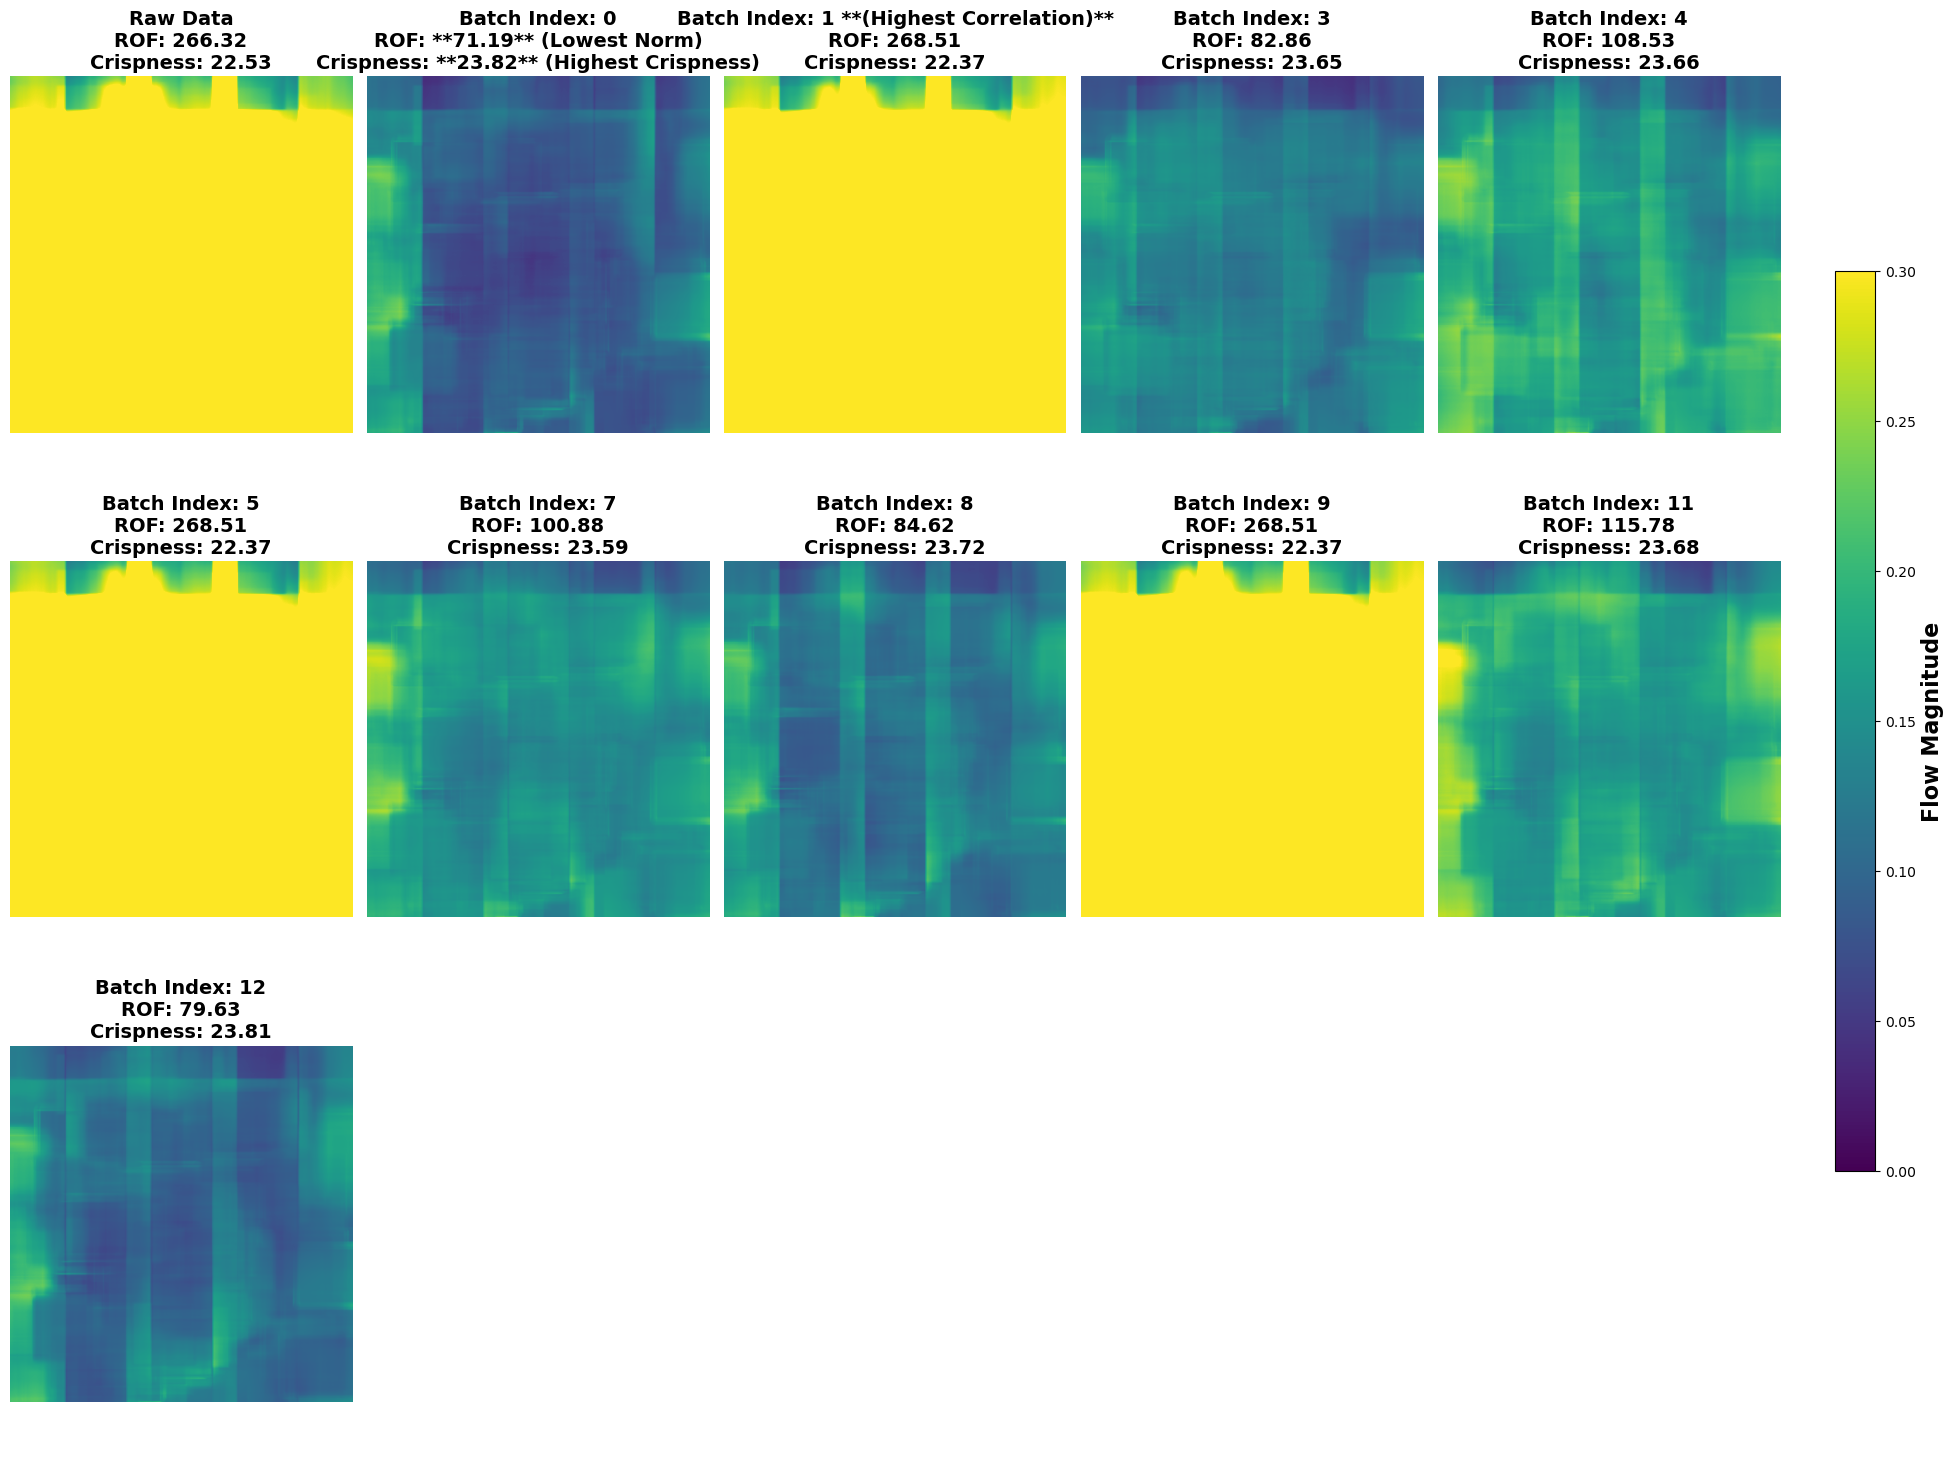

In [11]:
import lbm_caiman_python as lcp

# This will plot all batches.
lcp.plot_optical_flows(results, max_columns=5)

### Plot residual flows and correlations 

- `lcp.plot_residual_flows()` and `lcp.plot_correlations()` will first **sort your results by the corresponding metric**.
- Use the `num_batches` argument to display just the **best results** and avoid cluttering your figure
- Increase the number of batches to see groupings
- You can then see the batch index in the key to query back to your metrics results and see if any parameters led to metrics being grouped

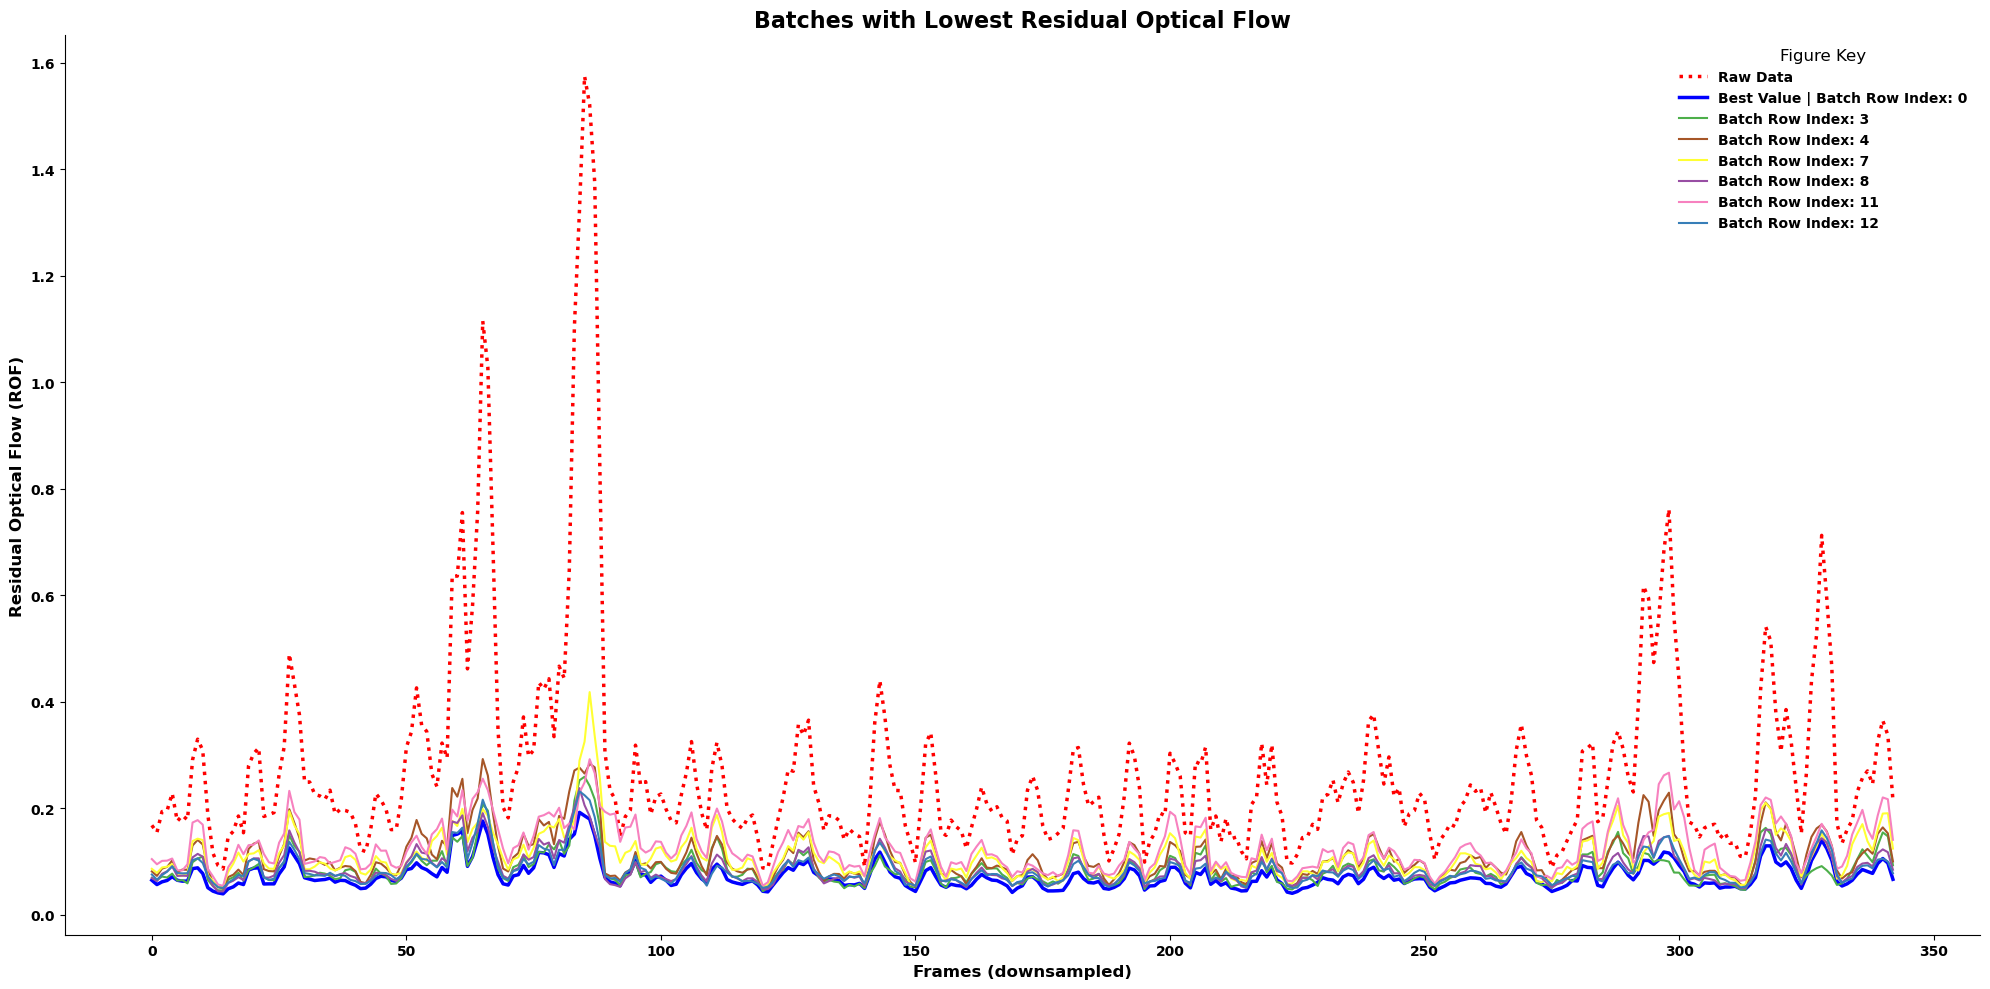

In [17]:
lcp.plot_residual_flows(results, num_batches=8, smooth=True, winsize=3)

Now, show only the best 2 batch runs as determiend by residual optical flow without smoothing
```{note}
No matter how many batches you decide to include, the raw data will be displayed as well in a dotted line.

If your raw data **is the best result**, it will be a blue dotted line.
```

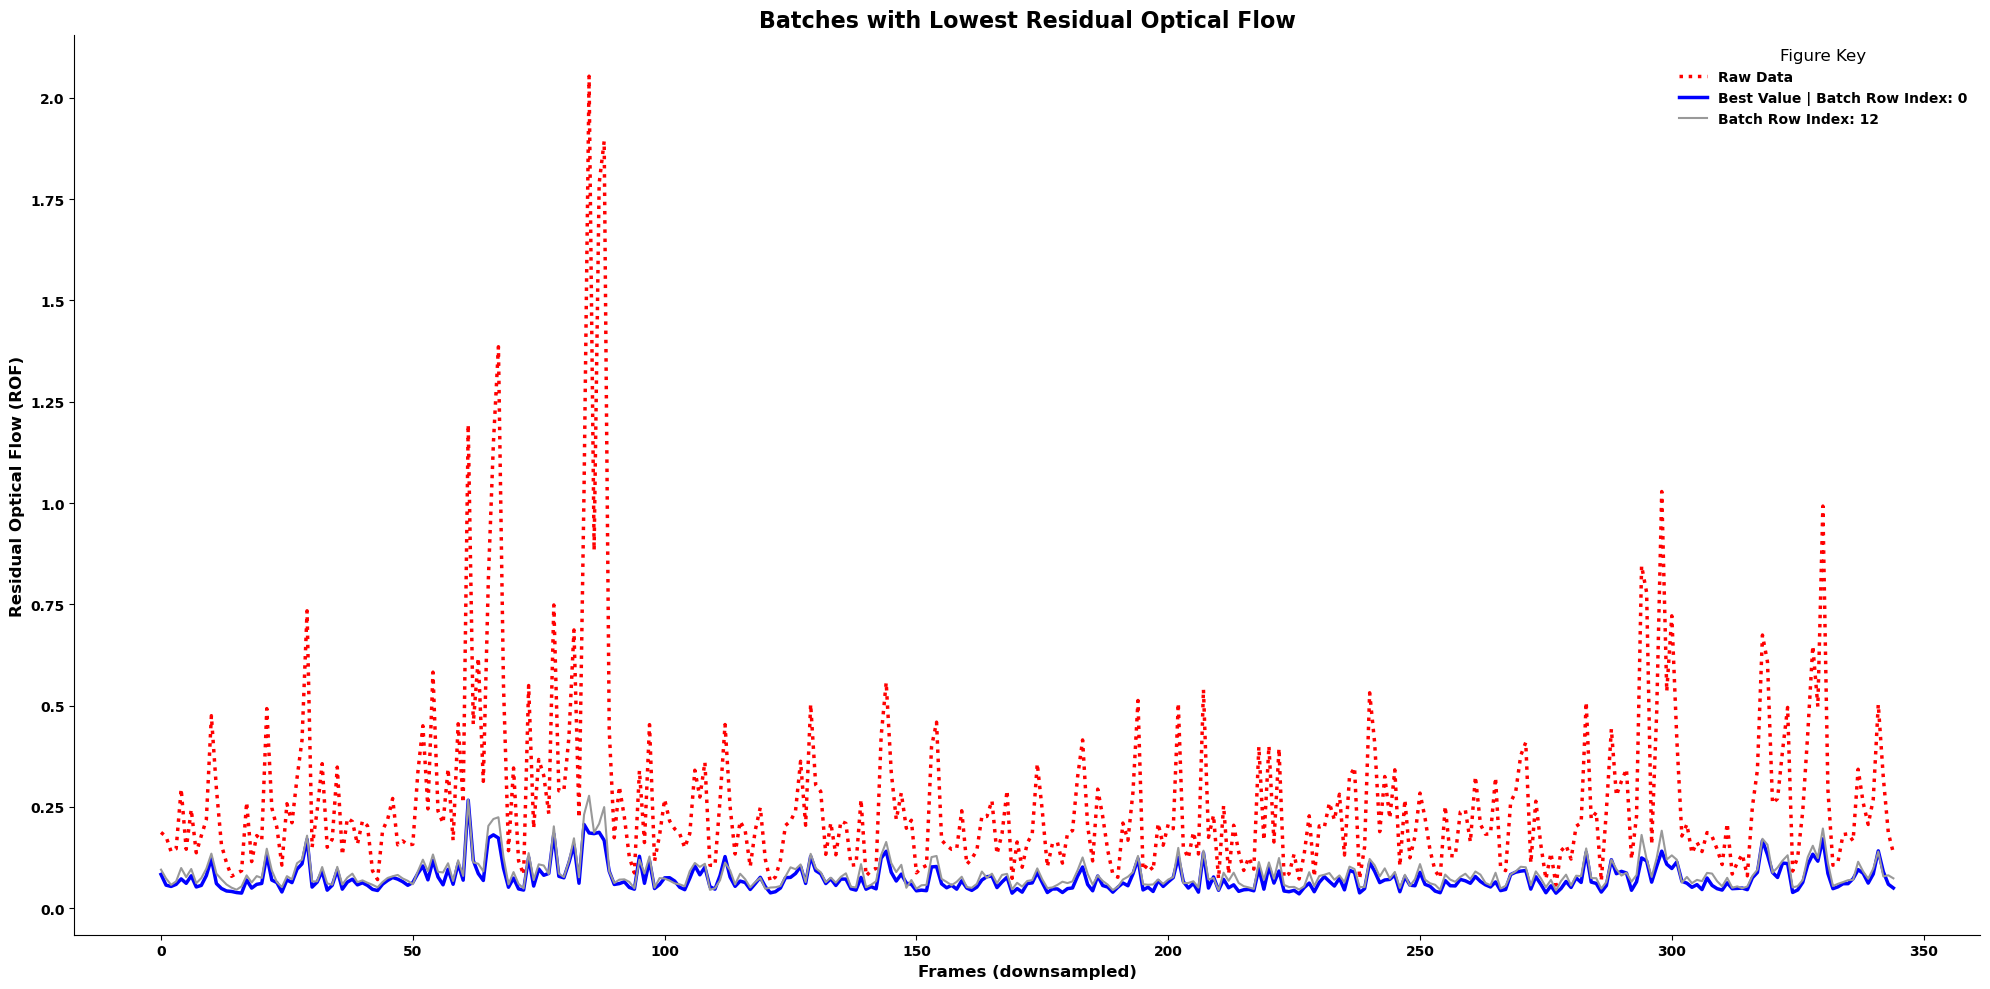

In [19]:
lcp.plot_residual_flows(results, num_batches=2, smooth=False)

Notice how there are many batch results that seem to align perfectly with the "best" result.

Correlation here is defined as the mean pixel correlation for each frame to the correlation image **within each movie**. As such, it is 

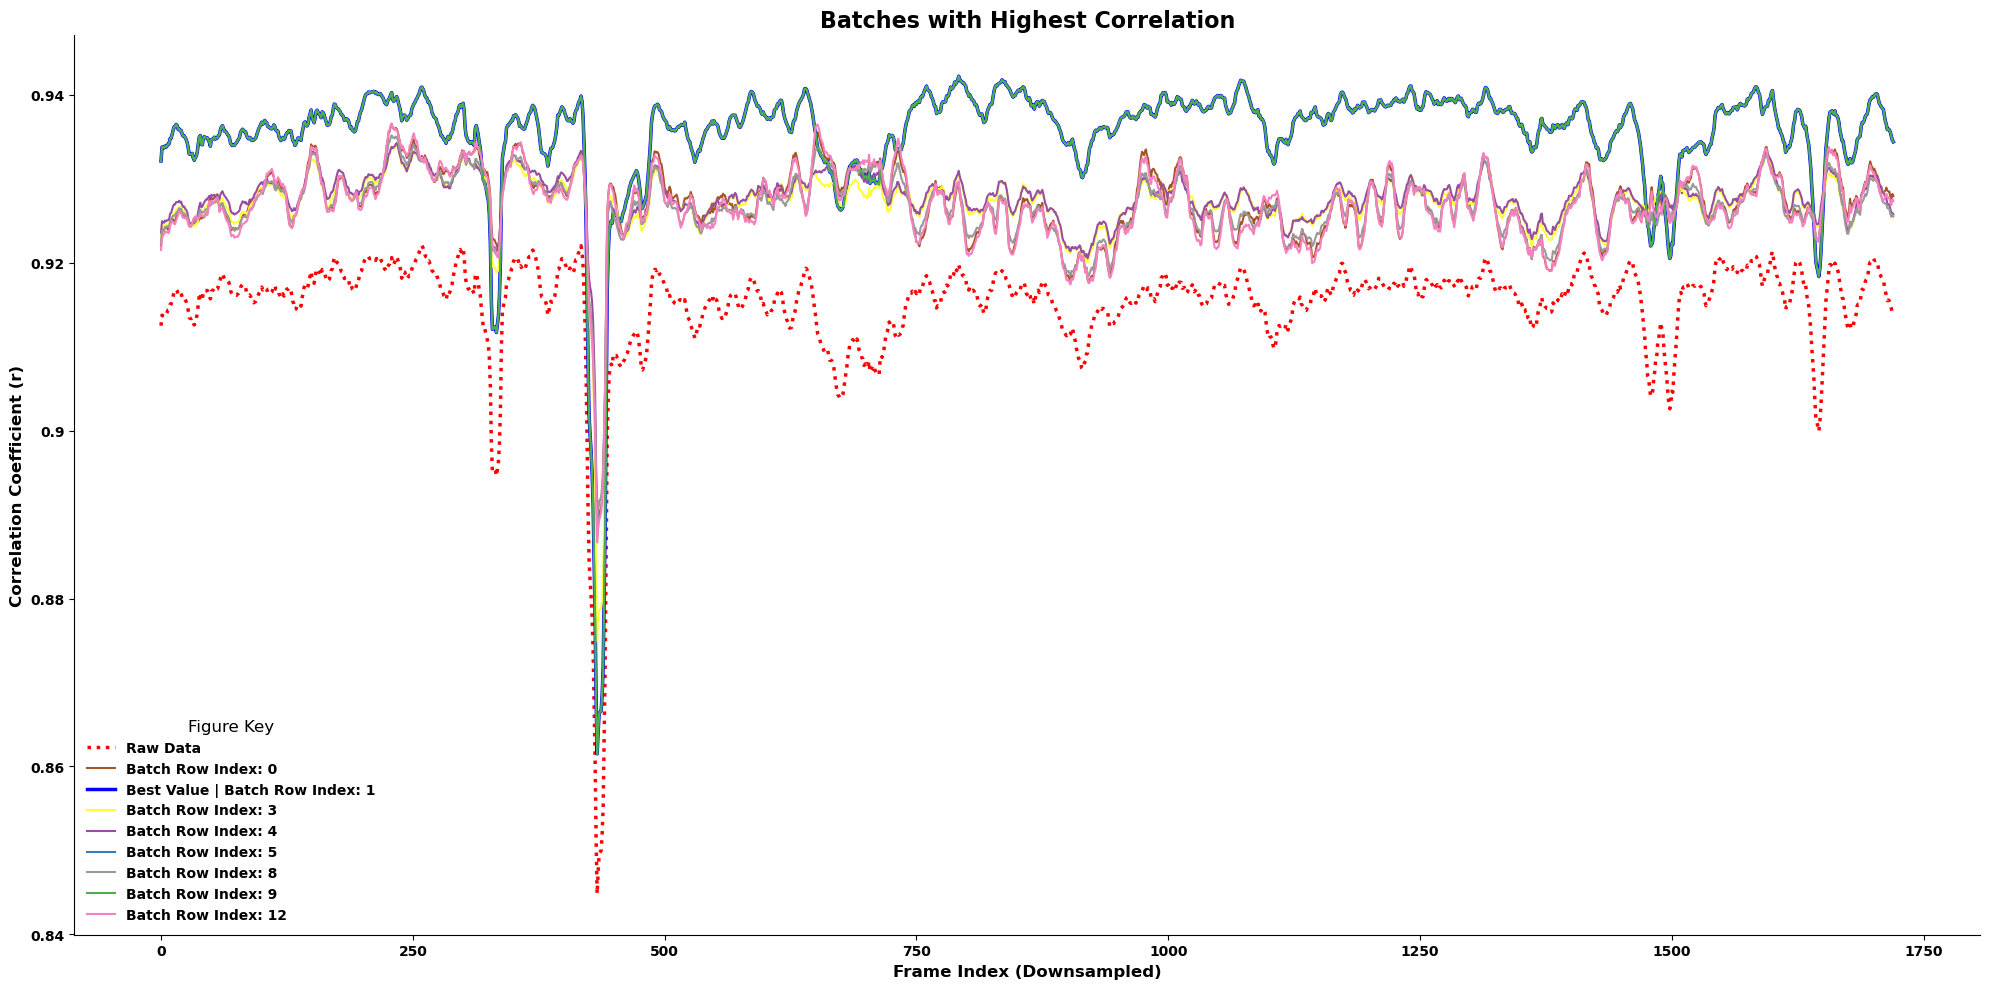

In [16]:
lcp.plot_correlations(results, num_batches=8, smooth=True, winsize=10)

## Difference of Gaussian Blur

In [81]:
from ipywidgets import IntSlider, VBox, HBox, FloatSlider
from caiman.motion_correction import high_pass_filter_space

movie_A = movies[0] # raw
movie_B = movies[1] # first registration run

blur_A_slider = IntSlider(value=1, min=1, max=33, step=1,  description="high-pass-filter A (σ)")
blur_B_slider = IntSlider(value=2, min=1, max=33, step=1,  description="high-pass-filter B (σ)")

def apply_filter(frame):
    # read slider value
    blur_A = (blur_A_slider.value, blur_A_slider.value)
    blur_B = (blur_B_slider.value, blur_B_slider.value)

    # this frame now has 2 images, with different sigma values
    blured_img_A = high_pass_filter_space(frame, blur_A)
    blured_img_B = high_pass_filter_space(frame, blur_B)

    diff = blured_img_A - blured_img_B
    return diff

def diff_frame(frame):
    # current time index
    # grab the current data at this index 
    fa =  iw_gs.managed_graphics[1].data[:]
    fb =  iw_gs.managed_graphics[0].data[:]
    
    diff = fa - fb
    
    iw_gs.managed_graphics[-1].data[:] = diff
    # iw_gs.reset_vmin_vmax()
    return diff
    
funcs = {
    0: apply_filter,
    1: apply_filter,
    2: diff_frame
}

# input movie will be shown on left, filtered on right
iw_gs = fpl.ImageWidget(
    data=[movie_A, movie_B, movie_A[0, ...]],
    frame_apply=funcs,
    names=[f"", f"filtered", "Difference"],
    figure_kwargs={"size": (1200, 600), "shape": (1, 3)},
    cmap="gray",
)

iw_gs.figure["filtered"].set_title(f"filtered σ=({blur_A_slider.value},{blur_B_slider.value})")

def force_update(*args):
    # forces the images to update when the gSig_filt slider is moved
    iw_gs.current_index = iw_gs.current_index
    iw_gs.figure["filtered"].set_title(f"filtered σ=({blur_A_slider.value},{blur_B_slider.value})")
    iw_gs.reset_vmin_vmax()
    
iw_gs.reset_vmin_vmax()

blur_A_slider.observe(force_update, "value")
blur_B_slider.observe(force_update, "value")
# iw_gs.add_event_handler(diff_frame, "current_index")

for g in iw_gs.figure:
    g.toolbar=False

VBox([iw_gs.show(), blur_B_slider, blur_A_slider])

RFBOutputContext()

RFBOutputContext()

JupyterWgpuCanvas(css_height='700px', css_width='900px')
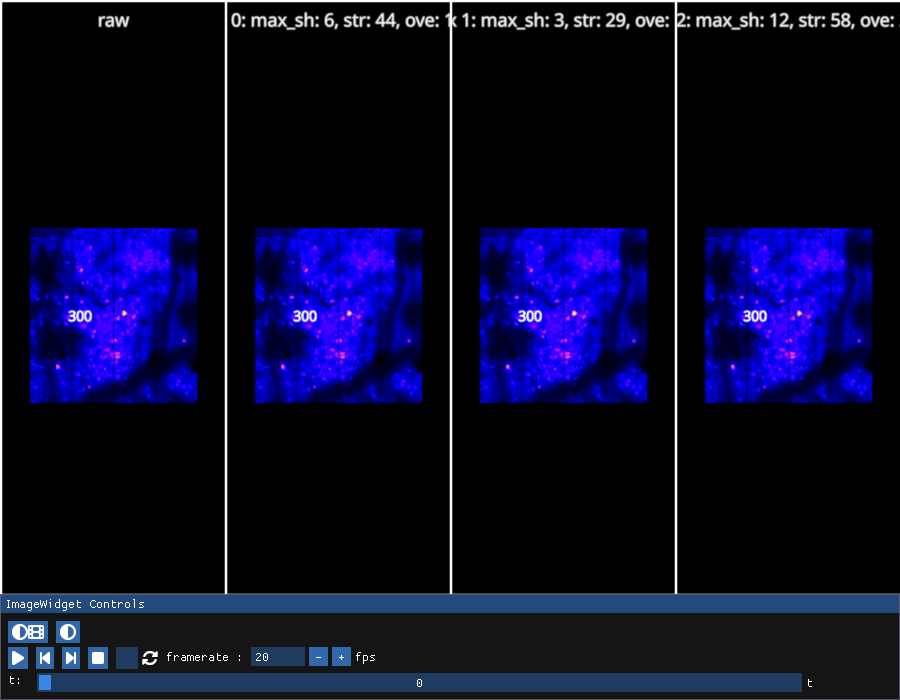

In [222]:
# Change the size/shape depending on how many parameter sweep inputs you used
figure_kwargs={"size": (900, 700), "shape": (1, len(movies))}

mcorr_iw_multiple = fpl.ImageWidget(
    data=movies,  # list of movies
    window_funcs={"t": (np.mean, 7)}, # window functions as a kwarg, this is what the slider was used for in the ready-made viz
    figure_kwargs=figure_kwargs,
    names=subplot_names,  # subplot names used for titles
    cmap="gnuplot2"
)

# free up some space
for subplot in mcorr_iw_multiple.figure:
    subplot.docks["right"].size = 0
    subplot.toolbar = False

mcorr_iw_multiple.show()

In [135]:
mcorr_iw_multiple.window_funcs["t"].window_size = 13

In [223]:
mcorr_iw_multiple.close()

# Apply the 'best parameters' to remaining files

When you decide which parameter set works the best, we keep it and delete the other batch items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

```{warning}
On windows, you will get an error `PermissionError: You do not have permissions to remove the output data for the batch item, aborting.` 

This can happen if you forgot to close one of the above widgets, or if you have a memory mapped file open.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

The solution is to restart your kernel. You will need to re-run the cells that define your batch/bath and reload your batch
with df = mc.load_batch(batch_path). Make sure `mc.set_raw_parent_data_path()` is in the re-run cells.
```

In [82]:
# UNCOMMENT THIS TO DELETE BATCH RUNS
# THIS IS COMMENTED OUT SO YOU DONT ACCIDENTALLY DELETE RESULTS YOU HAVE BEEN WAITING FOR ALL NIGHT!!!

# rows_keep = [2]
# for i, row in batch_df.iterrows():
#     if i not in rows_keep:
#         batch_df.caiman.remove_item(row.uuid, safe_removal=False)
# batch_df

## Apply registration using the same parameters to the remaining files

In [ ]:
for i in range(len(tiff_files)):

    # don't re-process the same file
    if tiff_files[i].name == df.iloc[0].input_movie_path:
        continue

    df.caiman.add_item(
        algo='mcorr',
        input_movie_path=tiff_files[i],
        params= df.iloc[0].params,          # use the same parameters
        item_name=f'{tiff_files[i].name}',  # filename of the movie, but can be anything
    )

Processing: /home/flynn/caiman_data/out2/plane_21.tiff
Processing: /home/flynn/caiman_data/out2/plane_1.tiff
Processing: /home/flynn/caiman_data/out2/plane_16.tiff


In [83]:
df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
1,mcorr,plane_0,plane_21.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,2918ff63-f204-4334-8837-ea172af89e39
2,mcorr,plane_2,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",None,2024-12-01T18:48:52,None,None,None,245bb955-feb9-4245-86bf-dd6ec1c79e95


In [84]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


finished computing correlation image
starting mc


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


finished computing correlation image
